In [1]:
import os
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from pyzbar import pyzbar
from ultralytics import YOLO
from paddleocr import PaddleOCR
import skimage.io as io
import skimage.restoration as denoise
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from pyzbar import pyzbar
import json
import os
import tempfile

In [2]:
ocr_model = PaddleOCR(lang='en', use_angle_cls=True)

[2024/06/19 09:10:11] ppocr DEBUG: Namespace(alpha=1.0, benchmark=False, beta=1.0, cls_batch_num=6, cls_image_shape='3, 48, 192', cls_model_dir='C:\\Users\\ferve/.paddleocr/whl\\cls\\ch_ppocr_mobile_v2.0_cls_infer', cls_thresh=0.9, cpu_threads=10, crop_res_save_dir='./output', det=True, det_algorithm='DB', det_box_type='quad', det_db_box_thresh=0.6, det_db_score_mode='fast', det_db_thresh=0.3, det_db_unclip_ratio=1.5, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_east_score_thresh=0.8, det_limit_side_len=960, det_limit_type='max', det_model_dir='C:\\Users\\ferve/.paddleocr/whl\\det\\en\\en_PP-OCRv3_det_infer', det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, det_pse_thresh=0, det_sast_nms_thresh=0.2, det_sast_score_thresh=0.5, draw_img_save_dir='./inference_results', drop_score=0.5, e2e_algorithm='PGNet', e2e_char_dict_path='./ppocr/utils/ic15_dict.txt', e2e_limit_side_len=768, e2e_limit_type='max', e2e_model_dir=None, e2e_pgnet_mode='fast', e2e_pgnet_score_thre

In [3]:
def extraer_imagenes(directorio):
    imagenes = []
    for archivo in os.listdir(directorio):
        if archivo.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
            ruta_completa = os.path.join(directorio, archivo)
            imagen = Image.open(ruta_completa)
            imagenes.append((archivo, imagen))
    return imagenes

In [4]:
def extraer_subimagenes(imagen, box_coords):
    subimagenes = []
    for box in box_coords:
        x1, y1, x2, y2 = box
        subimagen = imagen[y1:y2, x1:x2]
        subimagenes.append(subimagen)
    return subimagenes

In [5]:
def filtro1(imagen_procesada):
    imagen_procesada1 = cv2.cvtColor(imagen_procesada, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(4, 4))
    image = clahe.apply(imagen_procesada1)
    roi1 = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    roi1 = cv2.GaussianBlur(roi1, (3, 3), 2)
    imagen_procesada1 = cv2.cvtColor(roi1, cv2.COLOR_BGR2GRAY)
    image = clahe.apply(imagen_procesada1)
    roi1 = cv2.GaussianBlur(image, (5, 5), 2)
    
    return roi1

In [6]:

def filtro2(imagen):
    # Paso 1: Normalización
    norm_img = np.zeros((imagen.shape[0], imagen.shape[1]), dtype=np.uint8)
    imagen = cv2.normalize(imagen, norm_img, 0, 255, cv2.NORM_MINMAX)

    # Paso 3: Escalado de imagen
    def set_image_dpi(im):
        length_x, width_y = im.size
        factor = min(1, float(1024.0 / length_x))
        size = int(factor * length_x), int(factor * width_y)
        im_resized = im.resize(size, Image.LANCZOS)
        temp_file = tempfile.NamedTemporaryFile(delete=False, suffix='.png')
        temp_filename = temp_file.name
        im_resized.save(temp_filename, dpi=(300, 300))
        return temp_filename

    imagen_pil = Image.fromarray(cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB))
    temp_filename = set_image_dpi(imagen_pil)
    imagen = cv2.imread(temp_filename)

    # Paso 4: Eliminación de ruido
    def remove_noise(image):
        return cv2.fastNlMeansDenoisingColored(image, None, 10, 10, 7, 15)

    imagen = remove_noise(imagen)

    # Paso 5: Adelgazamiento y esqueletonización
    kernel = np.ones((5, 5), np.uint8)#np.ones((5, 5), np.uint8)
    imagen = cv2.erode(imagen, kernel, iterations=0)

    # Paso 6: Conversión a escala de grises
    def get_grayscale(image):
        return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    imagen = get_grayscale(imagen)

    # Paso 7: Umbralización o binarización
    def thresholding(image):
        return cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

    imagen = thresholding(imagen)

    return imagen


In [22]:
def filtro3(imagen_procesada):
    def thresholding(image):
        return cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
    imagen_procesada1 = cv2.cvtColor(imagen_procesada, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(4, 4))
    image = clahe.apply(imagen_procesada1)
    #roi1 = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    #roi1 = cv2.GaussianBlur(image, (3, 3), 2)
    roi1 = thresholding(imagen_procesada1)
    #imagen_procesada1 = cv2.cvtColor(roi1, cv2.COLOR_BGR2GRAY)
    #image = clahe.apply(imagen_procesada1)
    #roi1 = cv2.GaussianBlur(image, (3, 3), 0)
    
    return roi1

Encontrado código de barras (CODE39): 608005


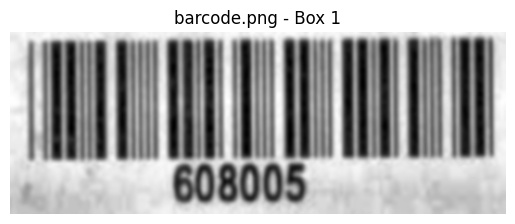

Encontrado código de barras (CODE128): DND123486


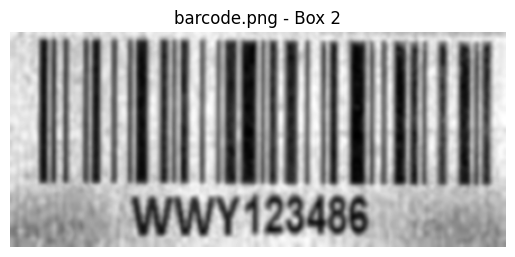

Sin código de barras legible
Comenzando con el reconocimiento OCR
[2024/06/19 09:28:22] ppocr DEBUG: dt_boxes num : 1, elapse : 0.07975602149963379
[2024/06/19 09:28:22] ppocr DEBUG: cls num  : 1, elapse : 0.030185222625732422
[2024/06/19 09:28:22] ppocr DEBUG: rec_res num  : 1, elapse : 0.20969724655151367
Código OCR encontrado: C670005


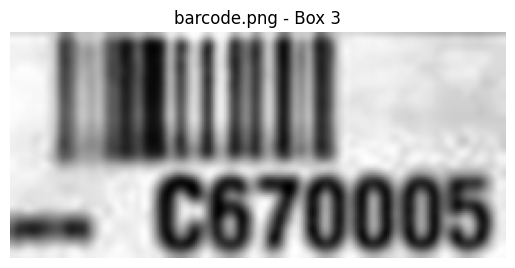

Encontrado código de barras (CODE39): 981070154 


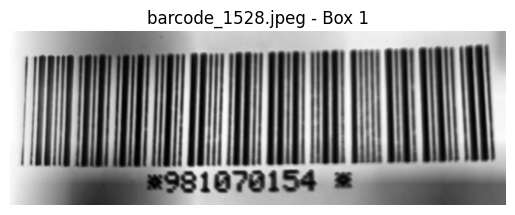

Encontrado código de barras (EAN13): 4100420015724


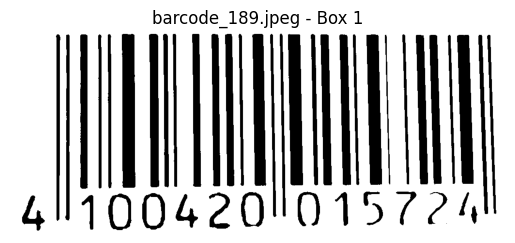

Encontrado código de barras (EAN13): 7800046004528


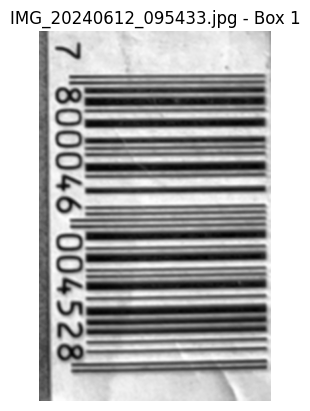

Encontrado código de barras (EAN13): 7800007804884


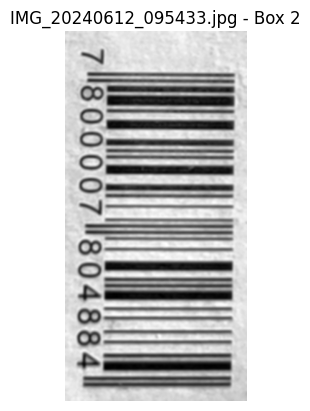

Encontrado código de barras (EAN13): 7800059003044


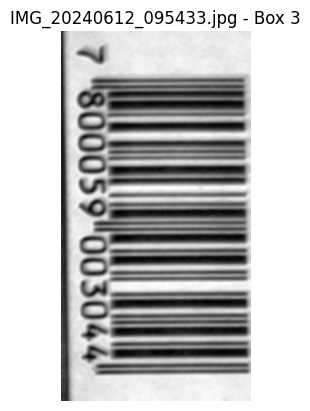

Encontrado código de barras (EAN13): 7804612010296


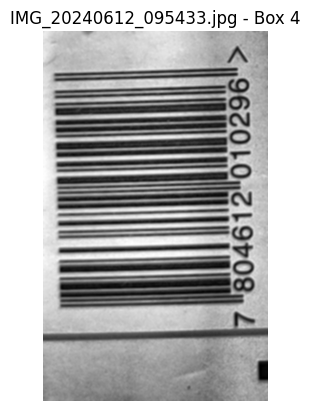

In [24]:

def guardar_en_json(data, nombre_archivo):
    with open(nombre_archivo, 'w') as f:
        json.dump(data, f, indent=4)

def mostrar_subimagenes(imagenes, grosor=2, umbral=0.65, output_json='resultados.json'):
    resultados = []
    
    for nombre, imagen in imagenes:
        imagen_cv2 = cv2.cvtColor(np.array(imagen), cv2.COLOR_RGB2BGR)
        results = model.predict(source=imagen_cv2, stream=True, verbose=False)
        
        box_coords = []
        for result in results:
            boxes = result.boxes.xyxy.cpu().numpy()
            confs = result.boxes.conf.cpu().numpy()
            for box, conf in zip(boxes, confs):
                if conf > umbral:
                    x1, y1, x2, y2 = map(int, box)
                    box_coords.append((x1, y1, x2, y2))

        subimagenes = extraer_subimagenes(imagen_cv2, box_coords)
        
        for i, subimagen in enumerate(subimagenes):
            imagen_filtrada = filtro1(subimagen)
            #_, binary_image = cv2.threshold(imagen_filtrada, 250, 251, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

            codigos_barras = pyzbar.decode(imagen_filtrada)
            info_imagen = {"id": nombre, "nombre_imagen": nombre, "codigos_barras": [], "ocr": []}

            for codigo in codigos_barras:
                x, y, w, h = codigo.rect
                cv2.rectangle(subimagen, (x, y), (x + w, y + h), (0, 255, 0), 2)
                texto_codigo = codigo.data.decode('utf-8')
                tipo_codigo = codigo.type
                cv2.putText(subimagen, f'{tipo_codigo}: {texto_codigo}', (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
                print(f"Encontrado código de barras ({tipo_codigo}): {texto_codigo}")
                info_imagen["codigos_barras"].append({"tipo": tipo_codigo, "texto": texto_codigo, "coordenadas": [x, y, w, h]})

            if not codigos_barras:
                imagen_filtrada = filtro2(subimagen)
                codigos_barras = pyzbar.decode(imagen_filtrada)
                info_imagen = {"id": nombre, "nombre_imagen": nombre, "codigos_barras": [], "ocr": []}

                for codigo in codigos_barras:
                    x, y, w, h = codigo.rect
                    cv2.rectangle(subimagen, (x, y), (x + w, y + h), (0, 255, 0), 2)
                    texto_codigo = codigo.data.decode('utf-8')
                    tipo_codigo = codigo.type
                    cv2.putText(subimagen, f'{tipo_codigo}: {texto_codigo}', (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
                    print(f"Encontrado código de barras ({tipo_codigo}): {texto_codigo}")
                    info_imagen["codigos_barras"].append({"tipo": tipo_codigo, "texto": texto_codigo, "coordenadas": [x, y, w, h]})

            if not codigos_barras:
                imagen_filtrada = filtro1(subimagen)
                print("Sin código de barras legible")
                print("Comenzando con el reconocimiento OCR")
                
                result1 = ocr_model.ocr(imagen_filtrada, cls=True)
                texts = [res1[1][0] for res1 in result1[0]]
                boxes1 = [res1[0] for res1 in result1[0]]
                ocr_info = []

                if len(texts) > 1:
                    texts = [' '.join(texts)]
                for text, box in zip(texts, boxes1):
                    print(f"Código OCR encontrado: {text}")
                    ocr_info.append({"texto": text, "coordenadas": box})
                info_imagen["ocr"].extend(ocr_info)
                if len (texts)<1:
                    imagen_filtrada = filtro3(subimagen)
                    print("Sin código de barras legible")
                    print("Comenzando con el reconocimiento OCR")
                    
                    result1 = ocr_model.ocr(imagen_filtrada, cls=True)
                    texts = [res1[1][0] for res1 in result1[0]]
                    boxes1 = [res1[0] for res1 in result1[0]]
                    ocr_info = []

                    if len(texts) > 1:
                        texts = [' '.join(texts)]
                    for text, box in zip(texts, boxes1):
                        print(f"Código OCR encontrado: {text}")
                        ocr_info.append({"texto": text, "coordenadas": box})
                    info_imagen["ocr"].extend(ocr_info)

                    if len (texts)<1:
                        print("Vuelva a sacar la foto")

            subimagen_rgb = cv2.cvtColor(subimagen, cv2.COLOR_BGR2RGB)
            plt.figure()
            plt.imshow(imagen_filtrada, cmap='gray')
            plt.title(f'{nombre} - Box {i+1}')
            plt.axis('off')
            plt.show()

            resultados.append(info_imagen)
    
    guardar_en_json(resultados, output_json)

model = YOLO("barras.pt")

directorio_imagenes = r'G:\INNOVAI\Test'
imagenes = extraer_imagenes(directorio_imagenes)
directorio_imagenes2 = r'G:\INNOVAI\barcode_advanceV0\Barcode_and_OCR'
output_json_path = os.path.join(directorio_imagenes2, 'resultados.json')
mostrar_subimagenes(imagenes, grosor=9, umbral=0.10, output_json=output_json_path)